In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip3 install numba
#!pip3 install cv2

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
from PIL import Image  

import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import shutil, random, os
train_path = './train'




## Load of the data

In [6]:
data = pd.read_csv("./train.csv",index_col='StudyInstanceUID')
#data.head()

## Exploratory Data Analysis

### Train.csv Analysis

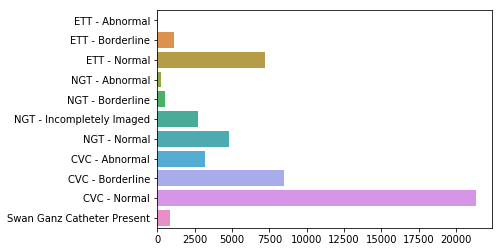

In [7]:
df_plot= data.drop('PatientID',axis=1).sum()
sns.barplot(x=df_plot.values, y=df_plot.index)


### Plot of NxN random samples

In [8]:
def plot_random_sample(df,N=5,title=True):

    filenames = random.sample(os.listdir(train_path), N*N)

    fig1, axes = plt.subplots(N,N ,sharex=True, sharey=True, figsize=(25, 15))

    for i,f in enumerate(filenames):

        ax1 = axes[i // N, i % N]


        img=Image.open(train_path+'/'+f)
        ax1.imshow(img)
        ax1.axis('off')
        if title:
            title_array=str('\n'.join(data.drop('PatientID',axis=1).loc[filenames[i][:-4]][data.drop('PatientID',axis=1).loc[filenames[i][:-4]]!=0].index.values))
            ax1.set_title(title_array,loc='left')
    plt.show()



In [9]:
filenames = random.sample(os.listdir(train_path), 2)

In [10]:
img=Image.open(train_path+'/'+filenames[0])


## Model 

In [11]:
data['combined_val'] = data[data.drop('PatientID',axis=1).columns].values.tolist()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.index.values,data['combined_val'], test_size=0.2, random_state=24)

In [14]:
image_size = 256
batch_size=26
num_epochs=25
frac_dataset_val=1

In [15]:
import numpy as np
import torch

class DatasetGui(torch.utils.data.Dataset):
        
    def __init__(self, df, transform=None):
        print('init begin')
        if transform is None:
            self.transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Resize((image_size, image_size)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        else:
            self.transform = transform
        self.df = df
        self.labels = self.df['combined_val'].values
        self.file_names = df.index.values
        print('init')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.file_names[idx]
        image_path = f'./train/{image_name}.jpg'
        #image = Image.open(image_path)
        #image = image.convert('RGB')
        #print(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_t = self.transform(image)
        label = self.labels[idx]
        return image_t,label
        

In [16]:
from torchvision import transforms


In [17]:

from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Linear
from tqdm import tqdm

path_model='../input/resnet200d-pretrained/resnet200d_pretrained.pth'

class Model_used(nn.Module):
    def __init__(self, model_name='resnet200d',pretrained=False):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=False)
        if pretrained:
            pretrained_path = path_model
            self.model.load_state_dict(torch.load(pretrained_path))
        
      
        
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, 11)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output



In [18]:
from torch import cuda
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()

In [19]:
def frac_dataset(df,rate):
    print(len(df))
    new_df=df.sample(frac=rate)
    print(len(new_df))
    return new_df

In [20]:
from torch.utils.data import DataLoader

data=frac_dataset(data,frac_dataset_val)

train_validation_frac = 0.8
train_data = data.sample(frac=train_validation_frac)
validation_data = data.drop(train_data.index)

train_dataset = DatasetGui(train_data)
validation_dataset = DatasetGui(validation_data)

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(validation_dataset)}

print(dataset_sizes)


train_dataset_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_dataset_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

30083
30083
init begin
init
init begin
init
{'train': 24066, 'val': 6017}


In [21]:
dataloaders = {
    'train': train_dataset_loader,
    'val': validation_dataset_loader
}

In [22]:
def train_model(model, criterion, optimizer, scheduler, train_updater,validation_updater,num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    mean_auc = []
    best_loss=10
    total_number = 0.0
    total_loss= 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            #running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.for i_batch, image in enumerate(tqdm(loader))
            #for inputs, labels in dataloaders[phase]:
            for i, val in enumerate(dataloaders[phase]):
                inputs, labels =val
                
                print(f'Round {i} of Dataloader')

                labels = torch.stack(labels)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    outputs=outputs.permute(1,0) #Use to correct the shape of the label
                    labels=labels.type_as(outputs)
                    
                    loss = criterion(outputs, labels)
                    
                    auc=roc_auc_compute_fn(outputs.detach().cpu(), labels.detach().cpu())
                    mean_auc.append(auc)
                    
                    #print(f'Epoch #{epoch} - {phase} | Loss for the {i}th Dataload: {loss} | Auc value:{auc}')
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                
                #running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
                
                total_number += inputs.size(0)
                total_loss += loss.item() * inputs.size(0)
                
                
            mean_loss=total_loss / total_number
            
            if phase == 'train':
                scheduler.step()
                
            
                
            torch.save(model.state_dict(),f'checkpoint_epoch_{epoch}.pth')
            #epoch_loss = running_loss / dataset_sizes[phase]
            
            #print('mean loss',mean_loss,'epoch loss', epoch_loss)
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            mean_auc_epoch=np.average(mean_auc)
            
            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(phase, mean_loss,mean_auc_epoch))
            
            
            if phase =='train':
                train_updater.update(**{"loss": mean_loss, "accuracy": mean_auc_epoch})
            
            # deep copy the model
            if phase == 'val' and mean_loss < best_loss:
                best_loss = mean_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('best model updated')
                validation_updater.update(**{"loss": mean_loss, "accuracy": mean_auc_epoch})
                
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    timestr = time.strftime("%Y%m%d-%H%M%S")
    print(timestr)
    torch.save(model.state_dict(),f'checkpoint{timestr}.pth')
    print('model saved')
    model.load_state_dict(best_model_wts)
    return model

In [23]:
def roc_auc_compute_fn(pred , label):
    try:
        from sklearn.metrics import roc_auc_score
    except ImportError:
        raise RuntimeError("This contrib module requires sklearn to be installed.")
    y_true = label.numpy()
    y_pred = pred.numpy()
    aucs = []
    for i in range(11):
        try:
            auc_class = roc_auc_score(label[i], pred[i])
        except:
            #print(f"couldn't compute auc for {i}th label. Assigning '0.5'")
            auc_class = 0.5
        aucs.append(auc_class)
    return np.mean(aucs)#, aucs

In [24]:
!pip3 install timm

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

import time

import timm
model=Model_used()
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
def compute_class_freqs(labels):
    
    labels = np.array(labels)
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [27]:
class GraphUpdater():
    def __init__(self, type, name=None):
        self.type = type
        if name is None:
            name = self.type + "_loss_auc_" + \
                str(int(datetime.timestamp(datetime.now())))
        self.name = name
        self.loss = []
        self.accuracy = []
        self.epoch = []

    def update(self, loss, accuracy):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.epoch.append(len(self.epoch))
        df = pd.DataFrame(
            data={"loss": self.loss, "accuracy": self.accuracy, "epoch": self.epoch})
        df.to_csv(self.name + ".csv", index_label="epoch")

    def display(self):
        df = pd.DataFrame(
            data={"loss": self.loss, "accuracy": self.accuracy, "epoch": self.epoch})
        df.plot(x="epoch", y=["loss", "accuracy"], title="[" +
                self.type + "]" + " Loss and Accuracy per epoch")
        plt.show()
        plt.savefig(self.name)


In [28]:
from datetime import datetime


In [29]:
train_updater = GraphUpdater(type="Train")
validation_updater = GraphUpdater(type="Validation")

In [30]:
model= train_model(model, criterion, optimizer_ft, exp_lr_scheduler
                       ,train_updater,validation_updater,num_epochs=num_epochs)

Epoch 0/24
----------
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader

Round 346 of Dataloader
Round 347 of Dataloader
Round 348 of Dataloader
Round 349 of Dataloader
Round 350 of Dataloader
Round 351 of Dataloader
Round 352 of Dataloader
Round 353 of Dataloader
Round 354 of Dataloader
Round 355 of Dataloader
Round 356 of Dataloader
Round 357 of Dataloader
Round 358 of Dataloader
Round 359 of Dataloader
Round 360 of Dataloader
Round 361 of Dataloader
Round 362 of Dataloader
Round 363 of Dataloader
Round 364 of Dataloader
Round 365 of Dataloader
Round 366 of Dataloader
Round 367 of Dataloader
Round 368 of Dataloader
Round 369 of Dataloader
Round 370 of Dataloader
Round 371 of Dataloader
Round 372 of Dataloader
Round 373 of Dataloader
Round 374 of Dataloader
Round 375 of Dataloader
Round 376 of Dataloader
Round 377 of Dataloader
Round 378 of Dataloader
Round 379 of Dataloader
Round 380 of Dataloader
Round 381 of Dataloader
Round 382 of Dataloader
Round 383 of Dataloader
Round 384 of Dataloader
Round 385 of Dataloader
Round 386 of Dataloader
Round 387 of Dat

Round 688 of Dataloader
Round 689 of Dataloader
Round 690 of Dataloader
Round 691 of Dataloader
Round 692 of Dataloader
Round 693 of Dataloader
Round 694 of Dataloader
Round 695 of Dataloader
Round 696 of Dataloader
Round 697 of Dataloader
Round 698 of Dataloader
Round 699 of Dataloader
Round 700 of Dataloader
Round 701 of Dataloader
Round 702 of Dataloader
Round 703 of Dataloader
Round 704 of Dataloader
Round 705 of Dataloader
Round 706 of Dataloader
Round 707 of Dataloader
Round 708 of Dataloader
Round 709 of Dataloader
Round 710 of Dataloader
Round 711 of Dataloader
Round 712 of Dataloader
Round 713 of Dataloader
Round 714 of Dataloader
Round 715 of Dataloader
Round 716 of Dataloader
Round 717 of Dataloader
Round 718 of Dataloader
Round 719 of Dataloader
Round 720 of Dataloader
Round 721 of Dataloader
Round 722 of Dataloader
Round 723 of Dataloader
Round 724 of Dataloader
Round 725 of Dataloader
Round 726 of Dataloader
Round 727 of Dataloader
Round 728 of Dataloader
Round 729 of Dat

Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dat

Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dataloader
Round 231 of Dataloader
Round 232 of Dataloader
Round 233 of Dataloader
Round 234 of Dataloader
Round 235 of Dataloader
Round 236 of Dataloader
Round 237 of Dataloader
Round 238 of Dataloader
Round 239 of Dataloader
Round 240 of Dataloader
Round 241 of Dataloader
Round 242 of Dataloader
Round 243 of Dataloader
Round 244 of Dataloader
Round 245 of Dataloader
Round 246 of Dataloader
Round 247 of Dataloader
Round 248 of Dataloader
Round 249 of Dataloader
Round 250 of Dataloader
Round 251 of Dataloader
Round 252 of Dataloader
Round 253 of Dataloader
Round 254 of Dataloader
Round 255 of Dataloader
Round 256 of Dataloader
Round 257 of Dataloader
Round 258 of Dataloader
Round 259 of Dat

Round 560 of Dataloader
Round 561 of Dataloader
Round 562 of Dataloader
Round 563 of Dataloader
Round 564 of Dataloader
Round 565 of Dataloader
Round 566 of Dataloader
Round 567 of Dataloader
Round 568 of Dataloader
Round 569 of Dataloader
Round 570 of Dataloader
Round 571 of Dataloader
Round 572 of Dataloader
Round 573 of Dataloader
Round 574 of Dataloader
Round 575 of Dataloader
Round 576 of Dataloader
Round 577 of Dataloader
Round 578 of Dataloader
Round 579 of Dataloader
Round 580 of Dataloader
Round 581 of Dataloader
Round 582 of Dataloader
Round 583 of Dataloader
Round 584 of Dataloader
Round 585 of Dataloader
Round 586 of Dataloader
Round 587 of Dataloader
Round 588 of Dataloader
Round 589 of Dataloader
Round 590 of Dataloader
Round 591 of Dataloader
Round 592 of Dataloader
Round 593 of Dataloader
Round 594 of Dataloader
Round 595 of Dataloader
Round 596 of Dataloader
Round 597 of Dataloader
Round 598 of Dataloader
Round 599 of Dataloader
Round 600 of Dataloader
Round 601 of Dat

Round 902 of Dataloader
Round 903 of Dataloader
Round 904 of Dataloader
Round 905 of Dataloader
Round 906 of Dataloader
Round 907 of Dataloader
Round 908 of Dataloader
Round 909 of Dataloader
Round 910 of Dataloader
Round 911 of Dataloader
Round 912 of Dataloader
Round 913 of Dataloader
Round 914 of Dataloader
Round 915 of Dataloader
Round 916 of Dataloader
Round 917 of Dataloader
Round 918 of Dataloader
Round 919 of Dataloader
Round 920 of Dataloader
Round 921 of Dataloader
Round 922 of Dataloader
Round 923 of Dataloader
Round 924 of Dataloader
Round 925 of Dataloader
train Loss: 0.2618  Acc: 0.6630
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of

Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Ro

Round 432 of Dataloader
Round 433 of Dataloader
Round 434 of Dataloader
Round 435 of Dataloader
Round 436 of Dataloader
Round 437 of Dataloader
Round 438 of Dataloader
Round 439 of Dataloader
Round 440 of Dataloader
Round 441 of Dataloader
Round 442 of Dataloader
Round 443 of Dataloader
Round 444 of Dataloader
Round 445 of Dataloader
Round 446 of Dataloader
Round 447 of Dataloader
Round 448 of Dataloader
Round 449 of Dataloader
Round 450 of Dataloader
Round 451 of Dataloader
Round 452 of Dataloader
Round 453 of Dataloader
Round 454 of Dataloader
Round 455 of Dataloader
Round 456 of Dataloader
Round 457 of Dataloader
Round 458 of Dataloader
Round 459 of Dataloader
Round 460 of Dataloader
Round 461 of Dataloader
Round 462 of Dataloader
Round 463 of Dataloader
Round 464 of Dataloader
Round 465 of Dataloader
Round 466 of Dataloader
Round 467 of Dataloader
Round 468 of Dataloader
Round 469 of Dataloader
Round 470 of Dataloader
Round 471 of Dataloader
Round 472 of Dataloader
Round 473 of Dat

Round 774 of Dataloader
Round 775 of Dataloader
Round 776 of Dataloader
Round 777 of Dataloader
Round 778 of Dataloader
Round 779 of Dataloader
Round 780 of Dataloader
Round 781 of Dataloader
Round 782 of Dataloader
Round 783 of Dataloader
Round 784 of Dataloader
Round 785 of Dataloader
Round 786 of Dataloader
Round 787 of Dataloader
Round 788 of Dataloader
Round 789 of Dataloader
Round 790 of Dataloader
Round 791 of Dataloader
Round 792 of Dataloader
Round 793 of Dataloader
Round 794 of Dataloader
Round 795 of Dataloader
Round 796 of Dataloader
Round 797 of Dataloader
Round 798 of Dataloader
Round 799 of Dataloader
Round 800 of Dataloader
Round 801 of Dataloader
Round 802 of Dataloader
Round 803 of Dataloader
Round 804 of Dataloader
Round 805 of Dataloader
Round 806 of Dataloader
Round 807 of Dataloader
Round 808 of Dataloader
Round 809 of Dataloader
Round 810 of Dataloader
Round 811 of Dataloader
Round 812 of Dataloader
Round 813 of Dataloader
Round 814 of Dataloader
Round 815 of Dat

Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dataloader
Round 231 of Dataloader
val Loss: 0.2534  Acc: 0.6745
best model updated
Epoch 3/24
----

Round 304 of Dataloader
Round 305 of Dataloader
Round 306 of Dataloader
Round 307 of Dataloader
Round 308 of Dataloader
Round 309 of Dataloader
Round 310 of Dataloader
Round 311 of Dataloader
Round 312 of Dataloader
Round 313 of Dataloader
Round 314 of Dataloader
Round 315 of Dataloader
Round 316 of Dataloader
Round 317 of Dataloader
Round 318 of Dataloader
Round 319 of Dataloader
Round 320 of Dataloader
Round 321 of Dataloader
Round 322 of Dataloader
Round 323 of Dataloader
Round 324 of Dataloader
Round 325 of Dataloader
Round 326 of Dataloader
Round 327 of Dataloader
Round 328 of Dataloader
Round 329 of Dataloader
Round 330 of Dataloader
Round 331 of Dataloader
Round 332 of Dataloader
Round 333 of Dataloader
Round 334 of Dataloader
Round 335 of Dataloader
Round 336 of Dataloader
Round 337 of Dataloader
Round 338 of Dataloader
Round 339 of Dataloader
Round 340 of Dataloader
Round 341 of Dataloader
Round 342 of Dataloader
Round 343 of Dataloader
Round 344 of Dataloader
Round 345 of Dat

Round 646 of Dataloader
Round 647 of Dataloader
Round 648 of Dataloader
Round 649 of Dataloader
Round 650 of Dataloader
Round 651 of Dataloader
Round 652 of Dataloader
Round 653 of Dataloader
Round 654 of Dataloader
Round 655 of Dataloader
Round 656 of Dataloader
Round 657 of Dataloader
Round 658 of Dataloader
Round 659 of Dataloader
Round 660 of Dataloader
Round 661 of Dataloader
Round 662 of Dataloader
Round 663 of Dataloader
Round 664 of Dataloader
Round 665 of Dataloader
Round 666 of Dataloader
Round 667 of Dataloader
Round 668 of Dataloader
Round 669 of Dataloader
Round 670 of Dataloader
Round 671 of Dataloader
Round 672 of Dataloader
Round 673 of Dataloader
Round 674 of Dataloader
Round 675 of Dataloader
Round 676 of Dataloader
Round 677 of Dataloader
Round 678 of Dataloader
Round 679 of Dataloader
Round 680 of Dataloader
Round 681 of Dataloader
Round 682 of Dataloader
Round 683 of Dataloader
Round 684 of Dataloader
Round 685 of Dataloader
Round 686 of Dataloader
Round 687 of Dat

Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Roun

Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dat

Round 519 of Dataloader
Round 520 of Dataloader
Round 521 of Dataloader
Round 522 of Dataloader
Round 523 of Dataloader
Round 524 of Dataloader
Round 525 of Dataloader
Round 526 of Dataloader
Round 527 of Dataloader
Round 528 of Dataloader
Round 529 of Dataloader
Round 530 of Dataloader
Round 531 of Dataloader
Round 532 of Dataloader
Round 533 of Dataloader
Round 534 of Dataloader
Round 535 of Dataloader
Round 536 of Dataloader
Round 537 of Dataloader
Round 538 of Dataloader
Round 539 of Dataloader
Round 540 of Dataloader
Round 541 of Dataloader
Round 542 of Dataloader
Round 543 of Dataloader
Round 544 of Dataloader
Round 545 of Dataloader
Round 546 of Dataloader
Round 547 of Dataloader
Round 548 of Dataloader
Round 549 of Dataloader
Round 550 of Dataloader
Round 551 of Dataloader
Round 552 of Dataloader
Round 553 of Dataloader
Round 554 of Dataloader
Round 555 of Dataloader
Round 556 of Dataloader
Round 557 of Dataloader
Round 558 of Dataloader
Round 559 of Dataloader
Round 560 of Dat

Round 861 of Dataloader
Round 862 of Dataloader
Round 863 of Dataloader
Round 864 of Dataloader
Round 865 of Dataloader
Round 866 of Dataloader
Round 867 of Dataloader
Round 868 of Dataloader
Round 869 of Dataloader
Round 870 of Dataloader
Round 871 of Dataloader
Round 872 of Dataloader
Round 873 of Dataloader
Round 874 of Dataloader
Round 875 of Dataloader
Round 876 of Dataloader
Round 877 of Dataloader
Round 878 of Dataloader
Round 879 of Dataloader
Round 880 of Dataloader
Round 881 of Dataloader
Round 882 of Dataloader
Round 883 of Dataloader
Round 884 of Dataloader
Round 885 of Dataloader
Round 886 of Dataloader
Round 887 of Dataloader
Round 888 of Dataloader
Round 889 of Dataloader
Round 890 of Dataloader
Round 891 of Dataloader
Round 892 of Dataloader
Round 893 of Dataloader
Round 894 of Dataloader
Round 895 of Dataloader
Round 896 of Dataloader
Round 897 of Dataloader
Round 898 of Dataloader
Round 899 of Dataloader
Round 900 of Dataloader
Round 901 of Dataloader
Round 902 of Dat

Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of

Round 392 of Dataloader
Round 393 of Dataloader
Round 394 of Dataloader
Round 395 of Dataloader
Round 396 of Dataloader
Round 397 of Dataloader
Round 398 of Dataloader
Round 399 of Dataloader
Round 400 of Dataloader
Round 401 of Dataloader
Round 402 of Dataloader
Round 403 of Dataloader
Round 404 of Dataloader
Round 405 of Dataloader
Round 406 of Dataloader
Round 407 of Dataloader
Round 408 of Dataloader
Round 409 of Dataloader
Round 410 of Dataloader
Round 411 of Dataloader
Round 412 of Dataloader
Round 413 of Dataloader
Round 414 of Dataloader
Round 415 of Dataloader
Round 416 of Dataloader
Round 417 of Dataloader
Round 418 of Dataloader
Round 419 of Dataloader
Round 420 of Dataloader
Round 421 of Dataloader
Round 422 of Dataloader
Round 423 of Dataloader
Round 424 of Dataloader
Round 425 of Dataloader
Round 426 of Dataloader
Round 427 of Dataloader
Round 428 of Dataloader
Round 429 of Dataloader
Round 430 of Dataloader
Round 431 of Dataloader
Round 432 of Dataloader
Round 433 of Dat

Round 734 of Dataloader
Round 735 of Dataloader
Round 736 of Dataloader
Round 737 of Dataloader
Round 738 of Dataloader
Round 739 of Dataloader
Round 740 of Dataloader
Round 741 of Dataloader
Round 742 of Dataloader
Round 743 of Dataloader
Round 744 of Dataloader
Round 745 of Dataloader
Round 746 of Dataloader
Round 747 of Dataloader
Round 748 of Dataloader
Round 749 of Dataloader
Round 750 of Dataloader
Round 751 of Dataloader
Round 752 of Dataloader
Round 753 of Dataloader
Round 754 of Dataloader
Round 755 of Dataloader
Round 756 of Dataloader
Round 757 of Dataloader
Round 758 of Dataloader
Round 759 of Dataloader
Round 760 of Dataloader
Round 761 of Dataloader
Round 762 of Dataloader
Round 763 of Dataloader
Round 764 of Dataloader
Round 765 of Dataloader
Round 766 of Dataloader
Round 767 of Dataloader
Round 768 of Dataloader
Round 769 of Dataloader
Round 770 of Dataloader
Round 771 of Dataloader
Round 772 of Dataloader
Round 773 of Dataloader
Round 774 of Dataloader
Round 775 of Dat

Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dataloader
Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dat

Round 264 of Dataloader
Round 265 of Dataloader
Round 266 of Dataloader
Round 267 of Dataloader
Round 268 of Dataloader
Round 269 of Dataloader
Round 270 of Dataloader
Round 271 of Dataloader
Round 272 of Dataloader
Round 273 of Dataloader
Round 274 of Dataloader
Round 275 of Dataloader
Round 276 of Dataloader
Round 277 of Dataloader
Round 278 of Dataloader
Round 279 of Dataloader
Round 280 of Dataloader
Round 281 of Dataloader
Round 282 of Dataloader
Round 283 of Dataloader
Round 284 of Dataloader
Round 285 of Dataloader
Round 286 of Dataloader
Round 287 of Dataloader
Round 288 of Dataloader
Round 289 of Dataloader
Round 290 of Dataloader
Round 291 of Dataloader
Round 292 of Dataloader
Round 293 of Dataloader
Round 294 of Dataloader
Round 295 of Dataloader
Round 296 of Dataloader
Round 297 of Dataloader
Round 298 of Dataloader
Round 299 of Dataloader
Round 300 of Dataloader
Round 301 of Dataloader
Round 302 of Dataloader
Round 303 of Dataloader
Round 304 of Dataloader
Round 305 of Dat

Round 606 of Dataloader
Round 607 of Dataloader
Round 608 of Dataloader
Round 609 of Dataloader
Round 610 of Dataloader
Round 611 of Dataloader
Round 612 of Dataloader
Round 613 of Dataloader
Round 614 of Dataloader
Round 615 of Dataloader
Round 616 of Dataloader
Round 617 of Dataloader
Round 618 of Dataloader
Round 619 of Dataloader
Round 620 of Dataloader
Round 621 of Dataloader
Round 622 of Dataloader
Round 623 of Dataloader
Round 624 of Dataloader
Round 625 of Dataloader
Round 626 of Dataloader
Round 627 of Dataloader
Round 628 of Dataloader
Round 629 of Dataloader
Round 630 of Dataloader
Round 631 of Dataloader
Round 632 of Dataloader
Round 633 of Dataloader
Round 634 of Dataloader
Round 635 of Dataloader
Round 636 of Dataloader
Round 637 of Dataloader
Round 638 of Dataloader
Round 639 of Dataloader
Round 640 of Dataloader
Round 641 of Dataloader
Round 642 of Dataloader
Round 643 of Dataloader
Round 644 of Dataloader
Round 645 of Dataloader
Round 646 of Dataloader
Round 647 of Dat

Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of

Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dataloader
Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dat

Round 479 of Dataloader
Round 480 of Dataloader
Round 481 of Dataloader
Round 482 of Dataloader
Round 483 of Dataloader
Round 484 of Dataloader
Round 485 of Dataloader
Round 486 of Dataloader
Round 487 of Dataloader
Round 488 of Dataloader
Round 489 of Dataloader
Round 490 of Dataloader
Round 491 of Dataloader
Round 492 of Dataloader
Round 493 of Dataloader
Round 494 of Dataloader
Round 495 of Dataloader
Round 496 of Dataloader
Round 497 of Dataloader
Round 498 of Dataloader
Round 499 of Dataloader
Round 500 of Dataloader
Round 501 of Dataloader
Round 502 of Dataloader
Round 503 of Dataloader
Round 504 of Dataloader
Round 505 of Dataloader
Round 506 of Dataloader
Round 507 of Dataloader
Round 508 of Dataloader
Round 509 of Dataloader
Round 510 of Dataloader
Round 511 of Dataloader
Round 512 of Dataloader
Round 513 of Dataloader
Round 514 of Dataloader
Round 515 of Dataloader
Round 516 of Dataloader
Round 517 of Dataloader
Round 518 of Dataloader
Round 519 of Dataloader
Round 520 of Dat

Round 821 of Dataloader
Round 822 of Dataloader
Round 823 of Dataloader
Round 824 of Dataloader
Round 825 of Dataloader
Round 826 of Dataloader
Round 827 of Dataloader
Round 828 of Dataloader
Round 829 of Dataloader
Round 830 of Dataloader
Round 831 of Dataloader
Round 832 of Dataloader
Round 833 of Dataloader
Round 834 of Dataloader
Round 835 of Dataloader
Round 836 of Dataloader
Round 837 of Dataloader
Round 838 of Dataloader
Round 839 of Dataloader
Round 840 of Dataloader
Round 841 of Dataloader
Round 842 of Dataloader
Round 843 of Dataloader
Round 844 of Dataloader
Round 845 of Dataloader
Round 846 of Dataloader
Round 847 of Dataloader
Round 848 of Dataloader
Round 849 of Dataloader
Round 850 of Dataloader
Round 851 of Dataloader
Round 852 of Dataloader
Round 853 of Dataloader
Round 854 of Dataloader
Round 855 of Dataloader
Round 856 of Dataloader
Round 857 of Dataloader
Round 858 of Dataloader
Round 859 of Dataloader
Round 860 of Dataloader
Round 861 of Dataloader
Round 862 of Dat

Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dat

Round 352 of Dataloader
Round 353 of Dataloader
Round 354 of Dataloader
Round 355 of Dataloader
Round 356 of Dataloader
Round 357 of Dataloader
Round 358 of Dataloader
Round 359 of Dataloader
Round 360 of Dataloader
Round 361 of Dataloader
Round 362 of Dataloader
Round 363 of Dataloader
Round 364 of Dataloader
Round 365 of Dataloader
Round 366 of Dataloader
Round 367 of Dataloader
Round 368 of Dataloader
Round 369 of Dataloader
Round 370 of Dataloader
Round 371 of Dataloader
Round 372 of Dataloader
Round 373 of Dataloader
Round 374 of Dataloader
Round 375 of Dataloader
Round 376 of Dataloader
Round 377 of Dataloader
Round 378 of Dataloader
Round 379 of Dataloader
Round 380 of Dataloader
Round 381 of Dataloader
Round 382 of Dataloader
Round 383 of Dataloader
Round 384 of Dataloader
Round 385 of Dataloader
Round 386 of Dataloader
Round 387 of Dataloader
Round 388 of Dataloader
Round 389 of Dataloader
Round 390 of Dataloader
Round 391 of Dataloader
Round 392 of Dataloader
Round 393 of Dat

Round 694 of Dataloader
Round 695 of Dataloader
Round 696 of Dataloader
Round 697 of Dataloader
Round 698 of Dataloader
Round 699 of Dataloader
Round 700 of Dataloader
Round 701 of Dataloader
Round 702 of Dataloader
Round 703 of Dataloader
Round 704 of Dataloader
Round 705 of Dataloader
Round 706 of Dataloader
Round 707 of Dataloader
Round 708 of Dataloader
Round 709 of Dataloader
Round 710 of Dataloader
Round 711 of Dataloader
Round 712 of Dataloader
Round 713 of Dataloader
Round 714 of Dataloader
Round 715 of Dataloader
Round 716 of Dataloader
Round 717 of Dataloader
Round 718 of Dataloader
Round 719 of Dataloader
Round 720 of Dataloader
Round 721 of Dataloader
Round 722 of Dataloader
Round 723 of Dataloader
Round 724 of Dataloader
Round 725 of Dataloader
Round 726 of Dataloader
Round 727 of Dataloader
Round 728 of Dataloader
Round 729 of Dataloader
Round 730 of Dataloader
Round 731 of Dataloader
Round 732 of Dataloader
Round 733 of Dataloader
Round 734 of Dataloader
Round 735 of Dat

Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dat

Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dataloader
Round 231 of Dataloader
Round 232 of Dataloader
Round 233 of Dataloader
Round 234 of Dataloader
Round 235 of Dataloader
Round 236 of Dataloader
Round 237 of Dataloader
Round 238 of Dataloader
Round 239 of Dataloader
Round 240 of Dataloader
Round 241 of Dataloader
Round 242 of Dataloader
Round 243 of Dataloader
Round 244 of Dataloader
Round 245 of Dataloader
Round 246 of Dataloader
Round 247 of Dataloader
Round 248 of Dataloader
Round 249 of Dataloader
Round 250 of Dataloader
Round 251 of Dataloader
Round 252 of Dataloader
Round 253 of Dataloader
Round 254 of Dataloader
Round 255 of Dataloader
Round 256 of Dataloader
Round 257 of Dataloader
Round 258 of Dataloader
Round 259 of Dataloader
Round 260 of Dataloader
Round 261 of Dataloader
Round 262 of Dataloader
Round 263 of Dataloader
Round 264 of Dataloader
Round 265 of Dat

Round 566 of Dataloader
Round 567 of Dataloader
Round 568 of Dataloader
Round 569 of Dataloader
Round 570 of Dataloader
Round 571 of Dataloader
Round 572 of Dataloader
Round 573 of Dataloader
Round 574 of Dataloader
Round 575 of Dataloader
Round 576 of Dataloader
Round 577 of Dataloader
Round 578 of Dataloader
Round 579 of Dataloader
Round 580 of Dataloader
Round 581 of Dataloader
Round 582 of Dataloader
Round 583 of Dataloader
Round 584 of Dataloader
Round 585 of Dataloader
Round 586 of Dataloader
Round 587 of Dataloader
Round 588 of Dataloader
Round 589 of Dataloader
Round 590 of Dataloader
Round 591 of Dataloader
Round 592 of Dataloader
Round 593 of Dataloader
Round 594 of Dataloader
Round 595 of Dataloader
Round 596 of Dataloader
Round 597 of Dataloader
Round 598 of Dataloader
Round 599 of Dataloader
Round 600 of Dataloader
Round 601 of Dataloader
Round 602 of Dataloader
Round 603 of Dataloader
Round 604 of Dataloader
Round 605 of Dataloader
Round 606 of Dataloader
Round 607 of Dat

Round 908 of Dataloader
Round 909 of Dataloader
Round 910 of Dataloader
Round 911 of Dataloader
Round 912 of Dataloader
Round 913 of Dataloader
Round 914 of Dataloader
Round 915 of Dataloader
Round 916 of Dataloader
Round 917 of Dataloader
Round 918 of Dataloader
Round 919 of Dataloader
Round 920 of Dataloader
Round 921 of Dataloader
Round 922 of Dataloader
Round 923 of Dataloader
Round 924 of Dataloader
Round 925 of Dataloader
train Loss: 0.2232  Acc: 0.7098
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Datal

Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Datalo

Round 439 of Dataloader
Round 440 of Dataloader
Round 441 of Dataloader
Round 442 of Dataloader
Round 443 of Dataloader
Round 444 of Dataloader
Round 445 of Dataloader
Round 446 of Dataloader
Round 447 of Dataloader
Round 448 of Dataloader
Round 449 of Dataloader
Round 450 of Dataloader
Round 451 of Dataloader
Round 452 of Dataloader
Round 453 of Dataloader
Round 454 of Dataloader
Round 455 of Dataloader
Round 456 of Dataloader
Round 457 of Dataloader
Round 458 of Dataloader
Round 459 of Dataloader
Round 460 of Dataloader
Round 461 of Dataloader
Round 462 of Dataloader
Round 463 of Dataloader
Round 464 of Dataloader
Round 465 of Dataloader
Round 466 of Dataloader
Round 467 of Dataloader
Round 468 of Dataloader
Round 469 of Dataloader
Round 470 of Dataloader
Round 471 of Dataloader
Round 472 of Dataloader
Round 473 of Dataloader
Round 474 of Dataloader
Round 475 of Dataloader
Round 476 of Dataloader
Round 477 of Dataloader
Round 478 of Dataloader
Round 479 of Dataloader
Round 480 of Dat

Round 781 of Dataloader
Round 782 of Dataloader
Round 783 of Dataloader
Round 784 of Dataloader
Round 785 of Dataloader
Round 786 of Dataloader
Round 787 of Dataloader
Round 788 of Dataloader
Round 789 of Dataloader
Round 790 of Dataloader
Round 791 of Dataloader
Round 792 of Dataloader
Round 793 of Dataloader
Round 794 of Dataloader
Round 795 of Dataloader
Round 796 of Dataloader
Round 797 of Dataloader
Round 798 of Dataloader
Round 799 of Dataloader
Round 800 of Dataloader
Round 801 of Dataloader
Round 802 of Dataloader
Round 803 of Dataloader
Round 804 of Dataloader
Round 805 of Dataloader
Round 806 of Dataloader
Round 807 of Dataloader
Round 808 of Dataloader
Round 809 of Dataloader
Round 810 of Dataloader
Round 811 of Dataloader
Round 812 of Dataloader
Round 813 of Dataloader
Round 814 of Dataloader
Round 815 of Dataloader
Round 816 of Dataloader
Round 817 of Dataloader
Round 818 of Dataloader
Round 819 of Dataloader
Round 820 of Dataloader
Round 821 of Dataloader
Round 822 of Dat

Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dataloader
Round 231 of Dataloader
val Loss: 0.2200  Acc: 0.7134
best model updated
Epoch 11/24
----------
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 

Round 311 of Dataloader
Round 312 of Dataloader
Round 313 of Dataloader
Round 314 of Dataloader
Round 315 of Dataloader
Round 316 of Dataloader
Round 317 of Dataloader
Round 318 of Dataloader
Round 319 of Dataloader
Round 320 of Dataloader
Round 321 of Dataloader
Round 322 of Dataloader
Round 323 of Dataloader
Round 324 of Dataloader
Round 325 of Dataloader
Round 326 of Dataloader
Round 327 of Dataloader
Round 328 of Dataloader
Round 329 of Dataloader
Round 330 of Dataloader
Round 331 of Dataloader
Round 332 of Dataloader
Round 333 of Dataloader
Round 334 of Dataloader
Round 335 of Dataloader
Round 336 of Dataloader
Round 337 of Dataloader
Round 338 of Dataloader
Round 339 of Dataloader
Round 340 of Dataloader
Round 341 of Dataloader
Round 342 of Dataloader
Round 343 of Dataloader
Round 344 of Dataloader
Round 345 of Dataloader
Round 346 of Dataloader
Round 347 of Dataloader
Round 348 of Dataloader
Round 349 of Dataloader
Round 350 of Dataloader
Round 351 of Dataloader
Round 352 of Dat

Round 653 of Dataloader
Round 654 of Dataloader
Round 655 of Dataloader
Round 656 of Dataloader
Round 657 of Dataloader
Round 658 of Dataloader
Round 659 of Dataloader
Round 660 of Dataloader
Round 661 of Dataloader
Round 662 of Dataloader
Round 663 of Dataloader
Round 664 of Dataloader
Round 665 of Dataloader
Round 666 of Dataloader
Round 667 of Dataloader
Round 668 of Dataloader
Round 669 of Dataloader
Round 670 of Dataloader
Round 671 of Dataloader
Round 672 of Dataloader
Round 673 of Dataloader
Round 674 of Dataloader
Round 675 of Dataloader
Round 676 of Dataloader
Round 677 of Dataloader
Round 678 of Dataloader
Round 679 of Dataloader
Round 680 of Dataloader
Round 681 of Dataloader
Round 682 of Dataloader
Round 683 of Dataloader
Round 684 of Dataloader
Round 685 of Dataloader
Round 686 of Dataloader
Round 687 of Dataloader
Round 688 of Dataloader
Round 689 of Dataloader
Round 690 of Dataloader
Round 691 of Dataloader
Round 692 of Dataloader
Round 693 of Dataloader
Round 694 of Dat

Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataload

Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dat

Round 526 of Dataloader
Round 527 of Dataloader
Round 528 of Dataloader
Round 529 of Dataloader
Round 530 of Dataloader
Round 531 of Dataloader
Round 532 of Dataloader
Round 533 of Dataloader
Round 534 of Dataloader
Round 535 of Dataloader
Round 536 of Dataloader
Round 537 of Dataloader
Round 538 of Dataloader
Round 539 of Dataloader
Round 540 of Dataloader
Round 541 of Dataloader
Round 542 of Dataloader
Round 543 of Dataloader
Round 544 of Dataloader
Round 545 of Dataloader
Round 546 of Dataloader
Round 547 of Dataloader
Round 548 of Dataloader
Round 549 of Dataloader
Round 550 of Dataloader
Round 551 of Dataloader
Round 552 of Dataloader
Round 553 of Dataloader
Round 554 of Dataloader
Round 555 of Dataloader
Round 556 of Dataloader
Round 557 of Dataloader
Round 558 of Dataloader
Round 559 of Dataloader
Round 560 of Dataloader
Round 561 of Dataloader
Round 562 of Dataloader
Round 563 of Dataloader
Round 564 of Dataloader
Round 565 of Dataloader
Round 566 of Dataloader
Round 567 of Dat

Round 868 of Dataloader
Round 869 of Dataloader
Round 870 of Dataloader
Round 871 of Dataloader
Round 872 of Dataloader
Round 873 of Dataloader
Round 874 of Dataloader
Round 875 of Dataloader
Round 876 of Dataloader
Round 877 of Dataloader
Round 878 of Dataloader
Round 879 of Dataloader
Round 880 of Dataloader
Round 881 of Dataloader
Round 882 of Dataloader
Round 883 of Dataloader
Round 884 of Dataloader
Round 885 of Dataloader
Round 886 of Dataloader
Round 887 of Dataloader
Round 888 of Dataloader
Round 889 of Dataloader
Round 890 of Dataloader
Round 891 of Dataloader
Round 892 of Dataloader
Round 893 of Dataloader
Round 894 of Dataloader
Round 895 of Dataloader
Round 896 of Dataloader
Round 897 of Dataloader
Round 898 of Dataloader
Round 899 of Dataloader
Round 900 of Dataloader
Round 901 of Dataloader
Round 902 of Dataloader
Round 903 of Dataloader
Round 904 of Dataloader
Round 905 of Dataloader
Round 906 of Dataloader
Round 907 of Dataloader
Round 908 of Dataloader
Round 909 of Dat

Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of

Round 399 of Dataloader
Round 400 of Dataloader
Round 401 of Dataloader
Round 402 of Dataloader
Round 403 of Dataloader
Round 404 of Dataloader
Round 405 of Dataloader
Round 406 of Dataloader
Round 407 of Dataloader
Round 408 of Dataloader
Round 409 of Dataloader
Round 410 of Dataloader
Round 411 of Dataloader
Round 412 of Dataloader
Round 413 of Dataloader
Round 414 of Dataloader
Round 415 of Dataloader
Round 416 of Dataloader
Round 417 of Dataloader
Round 418 of Dataloader
Round 419 of Dataloader
Round 420 of Dataloader
Round 421 of Dataloader
Round 422 of Dataloader
Round 423 of Dataloader
Round 424 of Dataloader
Round 425 of Dataloader
Round 426 of Dataloader
Round 427 of Dataloader
Round 428 of Dataloader
Round 429 of Dataloader
Round 430 of Dataloader
Round 431 of Dataloader
Round 432 of Dataloader
Round 433 of Dataloader
Round 434 of Dataloader
Round 435 of Dataloader
Round 436 of Dataloader
Round 437 of Dataloader
Round 438 of Dataloader
Round 439 of Dataloader
Round 440 of Dat

Round 741 of Dataloader
Round 742 of Dataloader
Round 743 of Dataloader
Round 744 of Dataloader
Round 745 of Dataloader
Round 746 of Dataloader
Round 747 of Dataloader
Round 748 of Dataloader
Round 749 of Dataloader
Round 750 of Dataloader
Round 751 of Dataloader
Round 752 of Dataloader
Round 753 of Dataloader
Round 754 of Dataloader
Round 755 of Dataloader
Round 756 of Dataloader
Round 757 of Dataloader
Round 758 of Dataloader
Round 759 of Dataloader
Round 760 of Dataloader
Round 761 of Dataloader
Round 762 of Dataloader
Round 763 of Dataloader
Round 764 of Dataloader
Round 765 of Dataloader
Round 766 of Dataloader
Round 767 of Dataloader
Round 768 of Dataloader
Round 769 of Dataloader
Round 770 of Dataloader
Round 771 of Dataloader
Round 772 of Dataloader
Round 773 of Dataloader
Round 774 of Dataloader
Round 775 of Dataloader
Round 776 of Dataloader
Round 777 of Dataloader
Round 778 of Dataloader
Round 779 of Dataloader
Round 780 of Dataloader
Round 781 of Dataloader
Round 782 of Dat

Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dataloader
Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dat

Round 271 of Dataloader
Round 272 of Dataloader
Round 273 of Dataloader
Round 274 of Dataloader
Round 275 of Dataloader
Round 276 of Dataloader
Round 277 of Dataloader
Round 278 of Dataloader
Round 279 of Dataloader
Round 280 of Dataloader
Round 281 of Dataloader
Round 282 of Dataloader
Round 283 of Dataloader
Round 284 of Dataloader
Round 285 of Dataloader
Round 286 of Dataloader
Round 287 of Dataloader
Round 288 of Dataloader
Round 289 of Dataloader
Round 290 of Dataloader
Round 291 of Dataloader
Round 292 of Dataloader
Round 293 of Dataloader
Round 294 of Dataloader
Round 295 of Dataloader
Round 296 of Dataloader
Round 297 of Dataloader
Round 298 of Dataloader
Round 299 of Dataloader
Round 300 of Dataloader
Round 301 of Dataloader
Round 302 of Dataloader
Round 303 of Dataloader
Round 304 of Dataloader
Round 305 of Dataloader
Round 306 of Dataloader
Round 307 of Dataloader
Round 308 of Dataloader
Round 309 of Dataloader
Round 310 of Dataloader
Round 311 of Dataloader
Round 312 of Dat

Round 613 of Dataloader
Round 614 of Dataloader
Round 615 of Dataloader
Round 616 of Dataloader
Round 617 of Dataloader
Round 618 of Dataloader
Round 619 of Dataloader
Round 620 of Dataloader
Round 621 of Dataloader
Round 622 of Dataloader
Round 623 of Dataloader
Round 624 of Dataloader
Round 625 of Dataloader
Round 626 of Dataloader
Round 627 of Dataloader
Round 628 of Dataloader
Round 629 of Dataloader
Round 630 of Dataloader
Round 631 of Dataloader
Round 632 of Dataloader
Round 633 of Dataloader
Round 634 of Dataloader
Round 635 of Dataloader
Round 636 of Dataloader
Round 637 of Dataloader
Round 638 of Dataloader
Round 639 of Dataloader
Round 640 of Dataloader
Round 641 of Dataloader
Round 642 of Dataloader
Round 643 of Dataloader
Round 644 of Dataloader
Round 645 of Dataloader
Round 646 of Dataloader
Round 647 of Dataloader
Round 648 of Dataloader
Round 649 of Dataloader
Round 650 of Dataloader
Round 651 of Dataloader
Round 652 of Dataloader
Round 653 of Dataloader
Round 654 of Dat

Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of

Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dataloader
Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dat

Round 485 of Dataloader
Round 486 of Dataloader
Round 487 of Dataloader
Round 488 of Dataloader
Round 489 of Dataloader
Round 490 of Dataloader
Round 491 of Dataloader
Round 492 of Dataloader
Round 493 of Dataloader
Round 494 of Dataloader
Round 495 of Dataloader
Round 496 of Dataloader
Round 497 of Dataloader
Round 498 of Dataloader
Round 499 of Dataloader
Round 500 of Dataloader
Round 501 of Dataloader
Round 502 of Dataloader
Round 503 of Dataloader
Round 504 of Dataloader
Round 505 of Dataloader
Round 506 of Dataloader
Round 507 of Dataloader
Round 508 of Dataloader
Round 509 of Dataloader
Round 510 of Dataloader
Round 511 of Dataloader
Round 512 of Dataloader
Round 513 of Dataloader
Round 514 of Dataloader
Round 515 of Dataloader
Round 516 of Dataloader
Round 517 of Dataloader
Round 518 of Dataloader
Round 519 of Dataloader
Round 520 of Dataloader
Round 521 of Dataloader
Round 522 of Dataloader
Round 523 of Dataloader
Round 524 of Dataloader
Round 525 of Dataloader
Round 526 of Dat

Round 827 of Dataloader
Round 828 of Dataloader
Round 829 of Dataloader
Round 830 of Dataloader
Round 831 of Dataloader
Round 832 of Dataloader
Round 833 of Dataloader
Round 834 of Dataloader
Round 835 of Dataloader
Round 836 of Dataloader
Round 837 of Dataloader
Round 838 of Dataloader
Round 839 of Dataloader
Round 840 of Dataloader
Round 841 of Dataloader
Round 842 of Dataloader
Round 843 of Dataloader
Round 844 of Dataloader
Round 845 of Dataloader
Round 846 of Dataloader
Round 847 of Dataloader
Round 848 of Dataloader
Round 849 of Dataloader
Round 850 of Dataloader
Round 851 of Dataloader
Round 852 of Dataloader
Round 853 of Dataloader
Round 854 of Dataloader
Round 855 of Dataloader
Round 856 of Dataloader
Round 857 of Dataloader
Round 858 of Dataloader
Round 859 of Dataloader
Round 860 of Dataloader
Round 861 of Dataloader
Round 862 of Dataloader
Round 863 of Dataloader
Round 864 of Dataloader
Round 865 of Dataloader
Round 866 of Dataloader
Round 867 of Dataloader
Round 868 of Dat

Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of

Round 358 of Dataloader
Round 359 of Dataloader
Round 360 of Dataloader
Round 361 of Dataloader
Round 362 of Dataloader
Round 363 of Dataloader
Round 364 of Dataloader
Round 365 of Dataloader
Round 366 of Dataloader
Round 367 of Dataloader
Round 368 of Dataloader
Round 369 of Dataloader
Round 370 of Dataloader
Round 371 of Dataloader
Round 372 of Dataloader
Round 373 of Dataloader
Round 374 of Dataloader
Round 375 of Dataloader
Round 376 of Dataloader
Round 377 of Dataloader
Round 378 of Dataloader
Round 379 of Dataloader
Round 380 of Dataloader
Round 381 of Dataloader
Round 382 of Dataloader
Round 383 of Dataloader
Round 384 of Dataloader
Round 385 of Dataloader
Round 386 of Dataloader
Round 387 of Dataloader
Round 388 of Dataloader
Round 389 of Dataloader
Round 390 of Dataloader
Round 391 of Dataloader
Round 392 of Dataloader
Round 393 of Dataloader
Round 394 of Dataloader
Round 395 of Dataloader
Round 396 of Dataloader
Round 397 of Dataloader
Round 398 of Dataloader
Round 399 of Dat

Round 700 of Dataloader
Round 701 of Dataloader
Round 702 of Dataloader
Round 703 of Dataloader
Round 704 of Dataloader
Round 705 of Dataloader
Round 706 of Dataloader
Round 707 of Dataloader
Round 708 of Dataloader
Round 709 of Dataloader
Round 710 of Dataloader
Round 711 of Dataloader
Round 712 of Dataloader
Round 713 of Dataloader
Round 714 of Dataloader
Round 715 of Dataloader
Round 716 of Dataloader
Round 717 of Dataloader
Round 718 of Dataloader
Round 719 of Dataloader
Round 720 of Dataloader
Round 721 of Dataloader
Round 722 of Dataloader
Round 723 of Dataloader
Round 724 of Dataloader
Round 725 of Dataloader
Round 726 of Dataloader
Round 727 of Dataloader
Round 728 of Dataloader
Round 729 of Dataloader
Round 730 of Dataloader
Round 731 of Dataloader
Round 732 of Dataloader
Round 733 of Dataloader
Round 734 of Dataloader
Round 735 of Dataloader
Round 736 of Dataloader
Round 737 of Dataloader
Round 738 of Dataloader
Round 739 of Dataloader
Round 740 of Dataloader
Round 741 of Dat

Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dat

Round 230 of Dataloader
Round 231 of Dataloader
Round 232 of Dataloader
Round 233 of Dataloader
Round 234 of Dataloader
Round 235 of Dataloader
Round 236 of Dataloader
Round 237 of Dataloader
Round 238 of Dataloader
Round 239 of Dataloader
Round 240 of Dataloader
Round 241 of Dataloader
Round 242 of Dataloader
Round 243 of Dataloader
Round 244 of Dataloader
Round 245 of Dataloader
Round 246 of Dataloader
Round 247 of Dataloader
Round 248 of Dataloader
Round 249 of Dataloader
Round 250 of Dataloader
Round 251 of Dataloader
Round 252 of Dataloader
Round 253 of Dataloader
Round 254 of Dataloader
Round 255 of Dataloader
Round 256 of Dataloader
Round 257 of Dataloader
Round 258 of Dataloader
Round 259 of Dataloader
Round 260 of Dataloader
Round 261 of Dataloader
Round 262 of Dataloader
Round 263 of Dataloader
Round 264 of Dataloader
Round 265 of Dataloader
Round 266 of Dataloader
Round 267 of Dataloader
Round 268 of Dataloader
Round 269 of Dataloader
Round 270 of Dataloader
Round 271 of Dat

Round 572 of Dataloader
Round 573 of Dataloader
Round 574 of Dataloader
Round 575 of Dataloader
Round 576 of Dataloader
Round 577 of Dataloader
Round 578 of Dataloader
Round 579 of Dataloader
Round 580 of Dataloader
Round 581 of Dataloader
Round 582 of Dataloader
Round 583 of Dataloader
Round 584 of Dataloader
Round 585 of Dataloader
Round 586 of Dataloader
Round 587 of Dataloader
Round 588 of Dataloader
Round 589 of Dataloader
Round 590 of Dataloader
Round 591 of Dataloader
Round 592 of Dataloader
Round 593 of Dataloader
Round 594 of Dataloader
Round 595 of Dataloader
Round 596 of Dataloader
Round 597 of Dataloader
Round 598 of Dataloader
Round 599 of Dataloader
Round 600 of Dataloader
Round 601 of Dataloader
Round 602 of Dataloader
Round 603 of Dataloader
Round 604 of Dataloader
Round 605 of Dataloader
Round 606 of Dataloader
Round 607 of Dataloader
Round 608 of Dataloader
Round 609 of Dataloader
Round 610 of Dataloader
Round 611 of Dataloader
Round 612 of Dataloader
Round 613 of Dat

Round 914 of Dataloader
Round 915 of Dataloader
Round 916 of Dataloader
Round 917 of Dataloader
Round 918 of Dataloader
Round 919 of Dataloader
Round 920 of Dataloader
Round 921 of Dataloader
Round 922 of Dataloader
Round 923 of Dataloader
Round 924 of Dataloader
Round 925 of Dataloader
train Loss: 0.2052  Acc: 0.7323
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dataloader
Round 14 of Dataloader
Round 15 of Dataloader
Round 16 of Dataloader
Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader


Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Dataloader
Round 120 of Dataloader
Round 121 of Dataloader
Round 122 of Dataloader
Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dat

Round 445 of Dataloader
Round 446 of Dataloader
Round 447 of Dataloader
Round 448 of Dataloader
Round 449 of Dataloader
Round 450 of Dataloader
Round 451 of Dataloader
Round 452 of Dataloader
Round 453 of Dataloader
Round 454 of Dataloader
Round 455 of Dataloader
Round 456 of Dataloader
Round 457 of Dataloader
Round 458 of Dataloader
Round 459 of Dataloader
Round 460 of Dataloader
Round 461 of Dataloader
Round 462 of Dataloader
Round 463 of Dataloader
Round 464 of Dataloader
Round 465 of Dataloader
Round 466 of Dataloader
Round 467 of Dataloader
Round 468 of Dataloader
Round 469 of Dataloader
Round 470 of Dataloader
Round 471 of Dataloader
Round 472 of Dataloader
Round 473 of Dataloader
Round 474 of Dataloader
Round 475 of Dataloader
Round 476 of Dataloader
Round 477 of Dataloader
Round 478 of Dataloader
Round 479 of Dataloader
Round 480 of Dataloader
Round 481 of Dataloader
Round 482 of Dataloader
Round 483 of Dataloader
Round 484 of Dataloader
Round 485 of Dataloader
Round 486 of Dat

Round 787 of Dataloader
Round 788 of Dataloader
Round 789 of Dataloader
Round 790 of Dataloader
Round 791 of Dataloader
Round 792 of Dataloader
Round 793 of Dataloader
Round 794 of Dataloader
Round 795 of Dataloader
Round 796 of Dataloader
Round 797 of Dataloader
Round 798 of Dataloader
Round 799 of Dataloader
Round 800 of Dataloader
Round 801 of Dataloader
Round 802 of Dataloader
Round 803 of Dataloader
Round 804 of Dataloader
Round 805 of Dataloader
Round 806 of Dataloader
Round 807 of Dataloader
Round 808 of Dataloader
Round 809 of Dataloader
Round 810 of Dataloader
Round 811 of Dataloader
Round 812 of Dataloader
Round 813 of Dataloader
Round 814 of Dataloader
Round 815 of Dataloader
Round 816 of Dataloader
Round 817 of Dataloader
Round 818 of Dataloader
Round 819 of Dataloader
Round 820 of Dataloader
Round 821 of Dataloader
Round 822 of Dataloader
Round 823 of Dataloader
Round 824 of Dataloader
Round 825 of Dataloader
Round 826 of Dataloader
Round 827 of Dataloader
Round 828 of Dat

Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dataloader
Round 231 of Dataloader
val Loss: 0.2037  Acc: 0.7341
best model updated
Epoch 19/24
----------
Round 0 of Dataloader
Round 1 of Dataloader
Round 2 of Dataloader
Round 3 of Dataloader
Round 4 of Dataloader
Round 5 of Dataloader
Round 6 of Dataloader
Round 7 of Dataloader
Round 8 of Dataloader
Round 9 of Dataloader
Round 10 of Dataloader
Round 11 of Dataloader
Round 12 of Dataloader
Round 13 of Dat

Round 317 of Dataloader
Round 318 of Dataloader
Round 319 of Dataloader
Round 320 of Dataloader
Round 321 of Dataloader
Round 322 of Dataloader
Round 323 of Dataloader
Round 324 of Dataloader
Round 325 of Dataloader
Round 326 of Dataloader
Round 327 of Dataloader
Round 328 of Dataloader
Round 329 of Dataloader
Round 330 of Dataloader
Round 331 of Dataloader
Round 332 of Dataloader
Round 333 of Dataloader
Round 334 of Dataloader
Round 335 of Dataloader
Round 336 of Dataloader
Round 337 of Dataloader
Round 338 of Dataloader
Round 339 of Dataloader
Round 340 of Dataloader
Round 341 of Dataloader
Round 342 of Dataloader
Round 343 of Dataloader
Round 344 of Dataloader
Round 345 of Dataloader
Round 346 of Dataloader
Round 347 of Dataloader
Round 348 of Dataloader
Round 349 of Dataloader
Round 350 of Dataloader
Round 351 of Dataloader
Round 352 of Dataloader
Round 353 of Dataloader
Round 354 of Dataloader
Round 355 of Dataloader
Round 356 of Dataloader
Round 357 of Dataloader
Round 358 of Dat

Round 659 of Dataloader
Round 660 of Dataloader
Round 661 of Dataloader
Round 662 of Dataloader
Round 663 of Dataloader
Round 664 of Dataloader
Round 665 of Dataloader
Round 666 of Dataloader
Round 667 of Dataloader
Round 668 of Dataloader
Round 669 of Dataloader
Round 670 of Dataloader
Round 671 of Dataloader
Round 672 of Dataloader
Round 673 of Dataloader
Round 674 of Dataloader
Round 675 of Dataloader
Round 676 of Dataloader
Round 677 of Dataloader
Round 678 of Dataloader
Round 679 of Dataloader
Round 680 of Dataloader
Round 681 of Dataloader
Round 682 of Dataloader
Round 683 of Dataloader
Round 684 of Dataloader
Round 685 of Dataloader
Round 686 of Dataloader
Round 687 of Dataloader
Round 688 of Dataloader
Round 689 of Dataloader
Round 690 of Dataloader
Round 691 of Dataloader
Round 692 of Dataloader
Round 693 of Dataloader
Round 694 of Dataloader
Round 695 of Dataloader
Round 696 of Dataloader
Round 697 of Dataloader
Round 698 of Dataloader
Round 699 of Dataloader
Round 700 of Dat

Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 103 of Dataloader
Round 104 of Dataloader
Round 105 of Dataloader
Round 106 of Dataloader
Round 107 of Dataloader
Round 108 of Dataloader
Round 109 of Dataloader
Round 110 of Dataloader
Round 111 of Dataloader
Round 112 of Dataloader
Round 113 of Dataloader
Round 114 of Dataloader
Round 115 of Dataloader
Round 116 of Dataloader
Round 117 of Dataloader
Round 118 of Dataloader
Round 119 of Da

Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dataloader
Round 207 of Dataloader
Round 208 of Dataloader
Round 209 of Dataloader
Round 210 of Dataloader
Round 211 of Dataloader
Round 212 of Dataloader
Round 213 of Dataloader
Round 214 of Dataloader
Round 215 of Dataloader
Round 216 of Dataloader
Round 217 of Dataloader
Round 218 of Dataloader
Round 219 of Dataloader
Round 220 of Dataloader
Round 221 of Dataloader
Round 222 of Dataloader
Round 223 of Dataloader
Round 224 of Dataloader
Round 225 of Dataloader
Round 226 of Dataloader
Round 227 of Dataloader
Round 228 of Dataloader
Round 229 of Dataloader
Round 230 of Dat

Round 531 of Dataloader
Round 532 of Dataloader
Round 533 of Dataloader
Round 534 of Dataloader
Round 535 of Dataloader
Round 536 of Dataloader
Round 537 of Dataloader
Round 538 of Dataloader
Round 539 of Dataloader
Round 540 of Dataloader
Round 541 of Dataloader
Round 542 of Dataloader
Round 543 of Dataloader
Round 544 of Dataloader
Round 545 of Dataloader
Round 546 of Dataloader
Round 547 of Dataloader
Round 548 of Dataloader
Round 549 of Dataloader
Round 550 of Dataloader
Round 551 of Dataloader
Round 552 of Dataloader
Round 553 of Dataloader
Round 554 of Dataloader
Round 555 of Dataloader
Round 556 of Dataloader
Round 557 of Dataloader
Round 558 of Dataloader
Round 559 of Dataloader
Round 560 of Dataloader
Round 561 of Dataloader
Round 562 of Dataloader
Round 563 of Dataloader
Round 564 of Dataloader
Round 565 of Dataloader
Round 566 of Dataloader
Round 567 of Dataloader
Round 568 of Dataloader
Round 569 of Dataloader
Round 570 of Dataloader
Round 571 of Dataloader
Round 572 of Dat

Round 873 of Dataloader
Round 874 of Dataloader
Round 875 of Dataloader
Round 876 of Dataloader
Round 877 of Dataloader
Round 878 of Dataloader
Round 879 of Dataloader
Round 880 of Dataloader
Round 881 of Dataloader
Round 882 of Dataloader
Round 883 of Dataloader
Round 884 of Dataloader
Round 885 of Dataloader
Round 886 of Dataloader
Round 887 of Dataloader
Round 888 of Dataloader
Round 889 of Dataloader
Round 890 of Dataloader
Round 891 of Dataloader
Round 892 of Dataloader
Round 893 of Dataloader
Round 894 of Dataloader
Round 895 of Dataloader
Round 896 of Dataloader
Round 897 of Dataloader
Round 898 of Dataloader
Round 899 of Dataloader
Round 900 of Dataloader
Round 901 of Dataloader
Round 902 of Dataloader
Round 903 of Dataloader
Round 904 of Dataloader
Round 905 of Dataloader
Round 906 of Dataloader
Round 907 of Dataloader
Round 908 of Dataloader
Round 909 of Dataloader
Round 910 of Dataloader
Round 911 of Dataloader
Round 912 of Dataloader
Round 913 of Dataloader
Round 914 of Dat

Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of Dataloader
Round 78 of Dataloader
Round 79 of Dataloader
Round 80 of Dataloader
Round 81 of Dataloader
Round 82 of Dataloader
Round 83 of Dataloader
Round 84 of Dataloader
Round 85 of Dataloader
Round 86 of Dataloader
Round 87 of Dataloader
Round 88 of Dataloader
Round 89 of Dataloader
Round 90 of Dataloader
Round 91 of Dataloader
Round 92 of Dataloader
Round 93 of Dataloader
Round 94 of Dataloader
Round 95 of Dataloader
Round 96 of Dataloader
Round 97 of Dataloader
Round 98 of Dataloader
Round 99 of Dataloader
Round 100 of Dataloader
Round 101 of Dataloader
Round 102 of Dataloader
Round 10

Round 404 of Dataloader
Round 405 of Dataloader
Round 406 of Dataloader
Round 407 of Dataloader
Round 408 of Dataloader
Round 409 of Dataloader
Round 410 of Dataloader
Round 411 of Dataloader
Round 412 of Dataloader
Round 413 of Dataloader
Round 414 of Dataloader
Round 415 of Dataloader
Round 416 of Dataloader
Round 417 of Dataloader
Round 418 of Dataloader
Round 419 of Dataloader
Round 420 of Dataloader
Round 421 of Dataloader
Round 422 of Dataloader
Round 423 of Dataloader
Round 424 of Dataloader
Round 425 of Dataloader
Round 426 of Dataloader
Round 427 of Dataloader
Round 428 of Dataloader
Round 429 of Dataloader
Round 430 of Dataloader
Round 431 of Dataloader
Round 432 of Dataloader
Round 433 of Dataloader
Round 434 of Dataloader
Round 435 of Dataloader
Round 436 of Dataloader
Round 437 of Dataloader
Round 438 of Dataloader
Round 439 of Dataloader
Round 440 of Dataloader
Round 441 of Dataloader
Round 442 of Dataloader
Round 443 of Dataloader
Round 444 of Dataloader
Round 445 of Dat

Round 746 of Dataloader
Round 747 of Dataloader
Round 748 of Dataloader
Round 749 of Dataloader
Round 750 of Dataloader
Round 751 of Dataloader
Round 752 of Dataloader
Round 753 of Dataloader
Round 754 of Dataloader
Round 755 of Dataloader
Round 756 of Dataloader
Round 757 of Dataloader
Round 758 of Dataloader
Round 759 of Dataloader
Round 760 of Dataloader
Round 761 of Dataloader
Round 762 of Dataloader
Round 763 of Dataloader
Round 764 of Dataloader
Round 765 of Dataloader
Round 766 of Dataloader
Round 767 of Dataloader
Round 768 of Dataloader
Round 769 of Dataloader
Round 770 of Dataloader
Round 771 of Dataloader
Round 772 of Dataloader
Round 773 of Dataloader
Round 774 of Dataloader
Round 775 of Dataloader
Round 776 of Dataloader
Round 777 of Dataloader
Round 778 of Dataloader
Round 779 of Dataloader
Round 780 of Dataloader
Round 781 of Dataloader
Round 782 of Dataloader
Round 783 of Dataloader
Round 784 of Dataloader
Round 785 of Dataloader
Round 786 of Dataloader
Round 787 of Dat

Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dataloader
Round 190 of Dataloader
Round 191 of Dataloader
Round 192 of Dataloader
Round 193 of Dataloader
Round 194 of Dataloader
Round 195 of Dataloader
Round 196 of Dataloader
Round 197 of Dataloader
Round 198 of Dataloader
Round 199 of Dataloader
Round 200 of Dataloader
Round 201 of Dataloader
Round 202 of Dataloader
Round 203 of Dataloader
Round 204 of Dataloader
Round 205 of Dataloader
Round 206 of Dat

Round 276 of Dataloader
Round 277 of Dataloader
Round 278 of Dataloader
Round 279 of Dataloader
Round 280 of Dataloader
Round 281 of Dataloader
Round 282 of Dataloader
Round 283 of Dataloader
Round 284 of Dataloader
Round 285 of Dataloader
Round 286 of Dataloader
Round 287 of Dataloader
Round 288 of Dataloader
Round 289 of Dataloader
Round 290 of Dataloader
Round 291 of Dataloader
Round 292 of Dataloader
Round 293 of Dataloader
Round 294 of Dataloader
Round 295 of Dataloader
Round 296 of Dataloader
Round 297 of Dataloader
Round 298 of Dataloader
Round 299 of Dataloader
Round 300 of Dataloader
Round 301 of Dataloader
Round 302 of Dataloader
Round 303 of Dataloader
Round 304 of Dataloader
Round 305 of Dataloader
Round 306 of Dataloader
Round 307 of Dataloader
Round 308 of Dataloader
Round 309 of Dataloader
Round 310 of Dataloader
Round 311 of Dataloader
Round 312 of Dataloader
Round 313 of Dataloader
Round 314 of Dataloader
Round 315 of Dataloader
Round 316 of Dataloader
Round 317 of Dat

Round 618 of Dataloader
Round 619 of Dataloader
Round 620 of Dataloader
Round 621 of Dataloader
Round 622 of Dataloader
Round 623 of Dataloader
Round 624 of Dataloader
Round 625 of Dataloader
Round 626 of Dataloader
Round 627 of Dataloader
Round 628 of Dataloader
Round 629 of Dataloader
Round 630 of Dataloader
Round 631 of Dataloader
Round 632 of Dataloader
Round 633 of Dataloader
Round 634 of Dataloader
Round 635 of Dataloader
Round 636 of Dataloader
Round 637 of Dataloader
Round 638 of Dataloader
Round 639 of Dataloader
Round 640 of Dataloader
Round 641 of Dataloader
Round 642 of Dataloader
Round 643 of Dataloader
Round 644 of Dataloader
Round 645 of Dataloader
Round 646 of Dataloader
Round 647 of Dataloader
Round 648 of Dataloader
Round 649 of Dataloader
Round 650 of Dataloader
Round 651 of Dataloader
Round 652 of Dataloader
Round 653 of Dataloader
Round 654 of Dataloader
Round 655 of Dataloader
Round 656 of Dataloader
Round 657 of Dataloader
Round 658 of Dataloader
Round 659 of Dat

Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of Dataloader
Round 61 of Dataloader
Round 62 of Dataloader
Round 63 of Dataloader
Round 64 of Dataloader
Round 65 of Dataloader
Round 66 of Dataloader
Round 67 of Dataloader
Round 68 of Dataloader
Round 69 of Dataloader
Round 70 of Dataloader
Round 71 of Dataloader
Round 72 of Dataloader
Round 73 of Dataloader
Round 74 of Dataloader
Round 75 of Dataloader
Round 76 of Dataloader
Round 77 of

Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dataloader
Round 165 of Dataloader
Round 166 of Dataloader
Round 167 of Dataloader
Round 168 of Dataloader
Round 169 of Dataloader
Round 170 of Dataloader
Round 171 of Dataloader
Round 172 of Dataloader
Round 173 of Dataloader
Round 174 of Dataloader
Round 175 of Dataloader
Round 176 of Dataloader
Round 177 of Dataloader
Round 178 of Dataloader
Round 179 of Dataloader
Round 180 of Dataloader
Round 181 of Dataloader
Round 182 of Dataloader
Round 183 of Dataloader
Round 184 of Dataloader
Round 185 of Dataloader
Round 186 of Dataloader
Round 187 of Dataloader
Round 188 of Dataloader
Round 189 of Dat

Round 490 of Dataloader
Round 491 of Dataloader
Round 492 of Dataloader
Round 493 of Dataloader
Round 494 of Dataloader
Round 495 of Dataloader
Round 496 of Dataloader
Round 497 of Dataloader
Round 498 of Dataloader
Round 499 of Dataloader
Round 500 of Dataloader
Round 501 of Dataloader
Round 502 of Dataloader
Round 503 of Dataloader
Round 504 of Dataloader
Round 505 of Dataloader
Round 506 of Dataloader
Round 507 of Dataloader
Round 508 of Dataloader
Round 509 of Dataloader
Round 510 of Dataloader
Round 511 of Dataloader
Round 512 of Dataloader
Round 513 of Dataloader
Round 514 of Dataloader
Round 515 of Dataloader
Round 516 of Dataloader
Round 517 of Dataloader
Round 518 of Dataloader
Round 519 of Dataloader
Round 520 of Dataloader
Round 521 of Dataloader
Round 522 of Dataloader
Round 523 of Dataloader
Round 524 of Dataloader
Round 525 of Dataloader
Round 526 of Dataloader
Round 527 of Dataloader
Round 528 of Dataloader
Round 529 of Dataloader
Round 530 of Dataloader
Round 531 of Dat

Round 832 of Dataloader
Round 833 of Dataloader
Round 834 of Dataloader
Round 835 of Dataloader
Round 836 of Dataloader
Round 837 of Dataloader
Round 838 of Dataloader
Round 839 of Dataloader
Round 840 of Dataloader
Round 841 of Dataloader
Round 842 of Dataloader
Round 843 of Dataloader
Round 844 of Dataloader
Round 845 of Dataloader
Round 846 of Dataloader
Round 847 of Dataloader
Round 848 of Dataloader
Round 849 of Dataloader
Round 850 of Dataloader
Round 851 of Dataloader
Round 852 of Dataloader
Round 853 of Dataloader
Round 854 of Dataloader
Round 855 of Dataloader
Round 856 of Dataloader
Round 857 of Dataloader
Round 858 of Dataloader
Round 859 of Dataloader
Round 860 of Dataloader
Round 861 of Dataloader
Round 862 of Dataloader
Round 863 of Dataloader
Round 864 of Dataloader
Round 865 of Dataloader
Round 866 of Dataloader
Round 867 of Dataloader
Round 868 of Dataloader
Round 869 of Dataloader
Round 870 of Dataloader
Round 871 of Dataloader
Round 872 of Dataloader
Round 873 of Dat

Round 17 of Dataloader
Round 18 of Dataloader
Round 19 of Dataloader
Round 20 of Dataloader
Round 21 of Dataloader
Round 22 of Dataloader
Round 23 of Dataloader
Round 24 of Dataloader
Round 25 of Dataloader
Round 26 of Dataloader
Round 27 of Dataloader
Round 28 of Dataloader
Round 29 of Dataloader
Round 30 of Dataloader
Round 31 of Dataloader
Round 32 of Dataloader
Round 33 of Dataloader
Round 34 of Dataloader
Round 35 of Dataloader
Round 36 of Dataloader
Round 37 of Dataloader
Round 38 of Dataloader
Round 39 of Dataloader
Round 40 of Dataloader
Round 41 of Dataloader
Round 42 of Dataloader
Round 43 of Dataloader
Round 44 of Dataloader
Round 45 of Dataloader
Round 46 of Dataloader
Round 47 of Dataloader
Round 48 of Dataloader
Round 49 of Dataloader
Round 50 of Dataloader
Round 51 of Dataloader
Round 52 of Dataloader
Round 53 of Dataloader
Round 54 of Dataloader
Round 55 of Dataloader
Round 56 of Dataloader
Round 57 of Dataloader
Round 58 of Dataloader
Round 59 of Dataloader
Round 60 of

Round 362 of Dataloader
Round 363 of Dataloader
Round 364 of Dataloader
Round 365 of Dataloader
Round 366 of Dataloader
Round 367 of Dataloader
Round 368 of Dataloader
Round 369 of Dataloader
Round 370 of Dataloader
Round 371 of Dataloader
Round 372 of Dataloader
Round 373 of Dataloader
Round 374 of Dataloader
Round 375 of Dataloader
Round 376 of Dataloader
Round 377 of Dataloader
Round 378 of Dataloader
Round 379 of Dataloader
Round 380 of Dataloader
Round 381 of Dataloader
Round 382 of Dataloader
Round 383 of Dataloader
Round 384 of Dataloader
Round 385 of Dataloader
Round 386 of Dataloader
Round 387 of Dataloader
Round 388 of Dataloader
Round 389 of Dataloader
Round 390 of Dataloader
Round 391 of Dataloader
Round 392 of Dataloader
Round 393 of Dataloader
Round 394 of Dataloader
Round 395 of Dataloader
Round 396 of Dataloader
Round 397 of Dataloader
Round 398 of Dataloader
Round 399 of Dataloader
Round 400 of Dataloader
Round 401 of Dataloader
Round 402 of Dataloader
Round 403 of Dat

Round 704 of Dataloader
Round 705 of Dataloader
Round 706 of Dataloader
Round 707 of Dataloader
Round 708 of Dataloader
Round 709 of Dataloader
Round 710 of Dataloader
Round 711 of Dataloader
Round 712 of Dataloader
Round 713 of Dataloader
Round 714 of Dataloader
Round 715 of Dataloader
Round 716 of Dataloader
Round 717 of Dataloader
Round 718 of Dataloader
Round 719 of Dataloader
Round 720 of Dataloader
Round 721 of Dataloader
Round 722 of Dataloader
Round 723 of Dataloader
Round 724 of Dataloader
Round 725 of Dataloader
Round 726 of Dataloader
Round 727 of Dataloader
Round 728 of Dataloader
Round 729 of Dataloader
Round 730 of Dataloader
Round 731 of Dataloader
Round 732 of Dataloader
Round 733 of Dataloader
Round 734 of Dataloader
Round 735 of Dataloader
Round 736 of Dataloader
Round 737 of Dataloader
Round 738 of Dataloader
Round 739 of Dataloader
Round 740 of Dataloader
Round 741 of Dataloader
Round 742 of Dataloader
Round 743 of Dataloader
Round 744 of Dataloader
Round 745 of Dat

Round 123 of Dataloader
Round 124 of Dataloader
Round 125 of Dataloader
Round 126 of Dataloader
Round 127 of Dataloader
Round 128 of Dataloader
Round 129 of Dataloader
Round 130 of Dataloader
Round 131 of Dataloader
Round 132 of Dataloader
Round 133 of Dataloader
Round 134 of Dataloader
Round 135 of Dataloader
Round 136 of Dataloader
Round 137 of Dataloader
Round 138 of Dataloader
Round 139 of Dataloader
Round 140 of Dataloader
Round 141 of Dataloader
Round 142 of Dataloader
Round 143 of Dataloader
Round 144 of Dataloader
Round 145 of Dataloader
Round 146 of Dataloader
Round 147 of Dataloader
Round 148 of Dataloader
Round 149 of Dataloader
Round 150 of Dataloader
Round 151 of Dataloader
Round 152 of Dataloader
Round 153 of Dataloader
Round 154 of Dataloader
Round 155 of Dataloader
Round 156 of Dataloader
Round 157 of Dataloader
Round 158 of Dataloader
Round 159 of Dataloader
Round 160 of Dataloader
Round 161 of Dataloader
Round 162 of Dataloader
Round 163 of Dataloader
Round 164 of Dat

In [31]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
torch.save(model.state_dict(),f'checkpoint{timestr}.pth')

20210310-054555
